In [3]:
# Copyright Amazon.com, Inc. or its affiliates. All Rights Reserved.
# SPDX-License-Identifier: Apache-2.0

# Test Synthetic Anomaly Injection on Real and Simulated Data
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl
import os
import sys
sys.path.append('/home/ubuntu/TSADModelSelection/') # TODO: Make this relative path maybe
sys.path.append('/home/ubuntu/PyMAD/') # TODO: Make this relative path maybe

from data.generate_synthetic_data import multivariate_ts
from model_selection.inject_anomalies import InjectAnomalies

## Synthetic Injection on Real Data
from src.pymad.datasets.load import load_data
from model_selection.utils import visualize_data

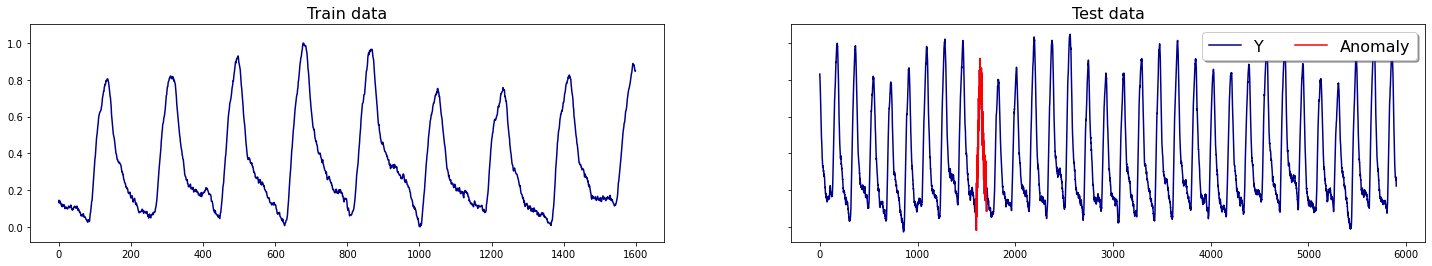

In [4]:
# Load the data
ENTITY = '028_UCR_Anomaly_DISTORTEDInternalBleeding17'
DATASET = 'anomaly_archive' # 'anomaly_archive'  'smd' 
train_data = load_data(dataset=DATASET, group='train', entities=[ENTITY], downsampling=10, min_length=256, root_dir='/home/ubuntu/datasets/', normalize=True, verbose=False)
test_data = load_data(dataset=DATASET, group='test', entities=[ENTITY], downsampling=10, min_length=256, root_dir='/home/ubuntu/datasets/', normalize=True, verbose=False)

# Now let's visualize the data
visualize_data(train_data, test_data)
## Now let's inject anomalies to the data and visualize it

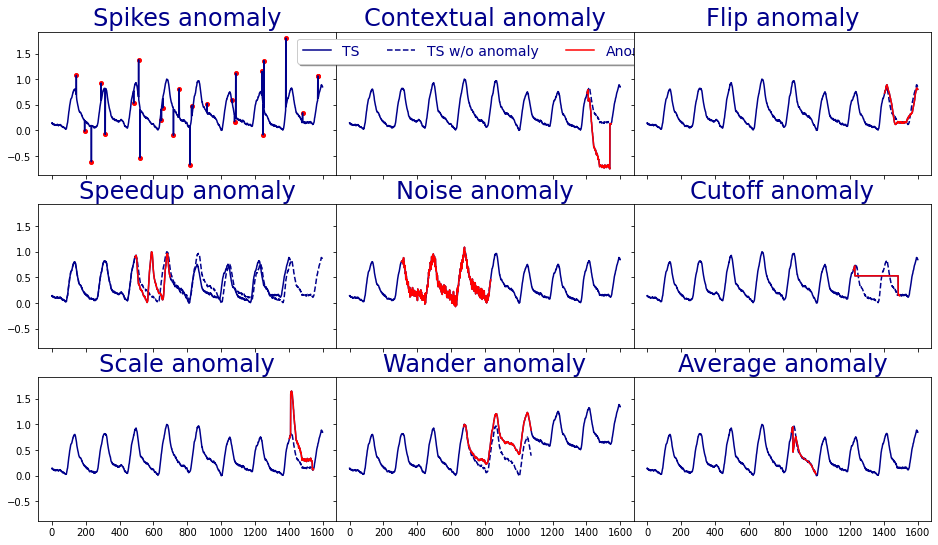

In [13]:
# plt.style.use('ggplot')
fig, axes = plt.subplots(3, 3, figsize=(16, 9), sharey=True, sharex=True)
axes = axes.flatten()

anomalyObj = InjectAnomalies(random_state=np.random.randint(10000), 
                                verbose=False, 
                                max_window_size=128, 
                                min_window_size=8)


for i, anomaly_type in enumerate(['spikes', 'contextual', 'flip', 'speedup', 'noise', 'cutoff', 'scale', 'wander', 'average']):
    T = train_data.entities[0].Y        
    data_std = max(np.std(T), 0.01)
    T_with_anomaly, anomaly_sizes, anomaly_labels = anomalyObj.inject_anomalies(T, 
                                                                scale=2*data_std, 
                                                                anomaly_type=anomaly_type,
                                                                random_parameters=False,
                                                                anomaly_size_type='mae',
                                                                anomaly_propensity=0.01,
                                                                max_anomaly_length=8,
                                                                constant_type='quantile', 
                                                                noise_std=0.05,
                                                                baseline=0.5, 
                                                                speed=2, 
                                                                amplitude_scaling=2, 
                                                                correlation_scaling=5,
                                                                ma_window=32)

    anomaly_start = np.argmax(anomaly_labels)
    anomaly_end = T_with_anomaly.shape[1] - np.argmax(anomaly_labels[::-1])

    # anomaly_sizes = anomaly_sizes/data_std
    axes[i].plot(T_with_anomaly.flatten(), color='darkblue', label='TS')
    
    if anomaly_type == 'spikes':
        for j, lab in enumerate(anomaly_labels):
            if lab == 1.: axes[i].scatter(j, T_with_anomaly.flatten()[j], color='red', s=16)
        
    elif anomaly_type == 'speedup':
        axes[i].plot(T.flatten(), color='darkblue', linestyle = '--')
        axes[i].plot(np.arange(anomaly_start, anomaly_end), T_with_anomaly.flatten()[anomaly_start:anomaly_end], color='red')
    else:
        axes[i].plot(np.arange(anomaly_start, anomaly_end), T.flatten()[anomaly_start:anomaly_end], color='darkblue', linestyle = '--', label='TS w/o anomaly')
        axes[i].plot(np.arange(anomaly_start, anomaly_end), T_with_anomaly.flatten()[anomaly_start:anomaly_end], color='red', label='Anomaly')
    
    axes[i].set_title(f'{anomaly_type.capitalize()} anomaly', fontsize=24, color='darkblue')
    # if i == 1: 
    #     axes[i].legend(loc='upper center', ncol=3, shadow=True, fancybox=True, labelcolor='darkblue', fontsize=14)

plt.subplots_adjust(wspace=0, hspace=0.2)
plt.savefig('anomalies.pdf')

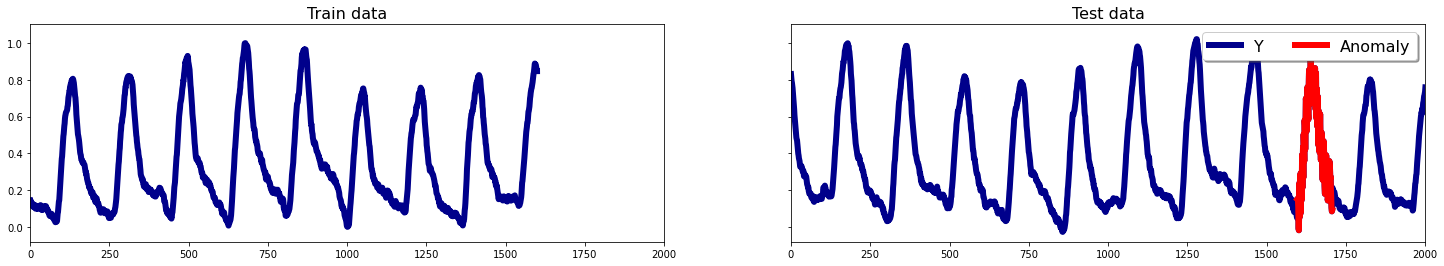

In [9]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(25, 4))
axes[0].plot(train_data.entities[0].Y.flatten(), color='darkblue', linewidth=6)
axes[0].set_title('Train data', fontsize=16)

start_anomaly = np.argmax(np.diff(test_data.entities[0].labels.flatten()))
end_anomaly = np.argmin(np.diff(test_data.entities[0].labels.flatten()))

axes[1].plot(test_data.entities[0].Y.flatten(), color='darkblue', label='Y', linewidth=6)
axes[1].plot(np.arange(start_anomaly, end_anomaly), test_data.entities[0].Y.flatten()[start_anomaly:end_anomaly], color='red', label='Anomaly', linewidth=6)
axes[1].set_title('Test data', fontsize=16)
axes[0].set_xlim(0, 2000)
axes[1].set_xlim(0, 2000)
axes[1].legend(fontsize=16, shadow=True, fancybox=True, ncol=2)

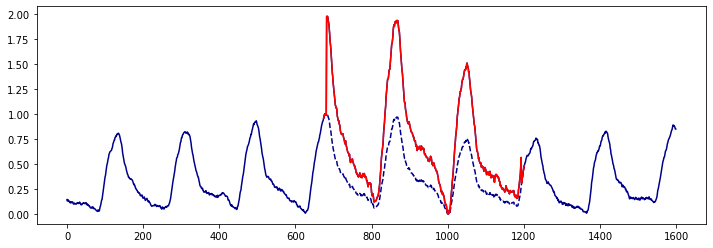

In [14]:
T = train_data.entities[0].Y        
data_std = max(np.std(T), 0.01)
T_with_anomaly, anomaly_sizes, anomaly_labels = anomalyObj.inject_anomalies(T, 
                                                            scale=2*data_std, 
                                                            anomaly_type='scale',
                                                            max_anomaly_length=6,
                                                            constant_type='quantile', 
                                                            speed=2, 
                                                            amplitude_scaling=2)
anomaly_start = np.argmax(anomaly_labels)
anomaly_end = T_with_anomaly.shape[1] - np.argmax(anomaly_labels[::-1])

fig, axes = plt.subplots(1, 1, sharey=True, figsize=(12, 4))
axes.plot(T_with_anomaly.flatten(), color='darkblue', label='TS')
axes.plot(np.arange(anomaly_start, anomaly_end), T.flatten()[anomaly_start:anomaly_end], color='darkblue', linestyle = '--', label='TS w/o anomaly')
axes.plot(np.arange(anomaly_start, anomaly_end), T_with_anomaly.flatten()[anomaly_start:anomaly_end], color='red', label='Anomaly')
axes[1].legend(fontsize=16, shadow=True, fancybox=True, ncol=3)